## A certain shop floor is represented as a 2-D grid of size n x m, as shown in the figure below.
 In
the shop floor, robots are employed to perform shipment tasks, where a task involves
shipping a component from a designated pick-up cell location to a destination cell. There are
‘k’ robots and ‘k’ shipment tasks. Each robot performs a single task. A robot can move at most
one cell (either vertically or horizontally) at a time step. A cell cannot be simultaneously
occupied by more than one robot. Black coloured cells are obstacles and cannot be traversed
through. All robots start at the same time. The ith robot starts from cell location Ri, picks up
one the components (say) at location Pj, delivers it in cell Ej and finally moves to cell Di. The
objective is to choose the appropriate task for each robot and determine its corresponding
travel path, so that overall completion time for the work schedule involving all tasks is
minimized.
Using the Google Colab environment, implement the ‘Conflict Based Search (CBS)’ algorithm
[1] for finding an optimal solution to the above problem. Compare time overheads of the
algorithm against a simple A* based implementation.

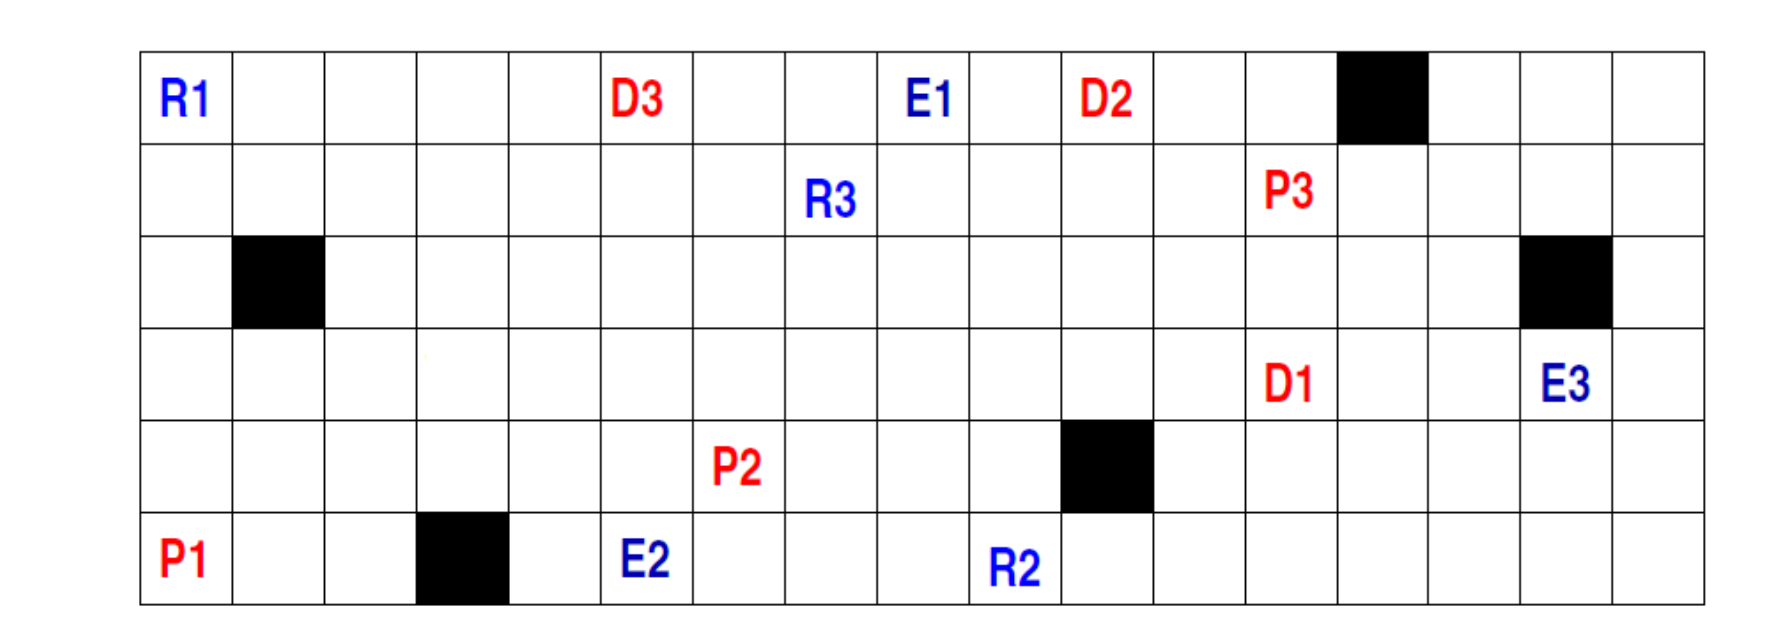

The above figure can be defined as : 

* grid size = (6,17)

* obstacles = [(1,14), (3,2), (3,16), (5,11), (6,4)]

* starts = [(1,1), (6,10),(2,8)]

* pickups = [(2,13), (5,7), (2,13)]

* deliveries = [(4,13), (1,11), (1,6)]

* ends = [(1,9),(6,6), (4,16)]

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
import time

# Defining a class for representing a node in the constraint tree
class Node:
    def __init__(self,starts , num_agents,ends, parent=None, agent=None, constraint=None):
        self.parent = parent # the parent node
        self.agent = agent # the agent index
        self.constraint = constraint # Constraint location and time
        self.starts= starts
        self.ends = ends
        self.num_agents = num_agents
        self.paths = [] # Paths for each agent
        self.cost = 0 # Cost of the node
        self.heuristic = 0 # Heuristic value of the node

        if parent is None: # the root node
            for i in range(num_agents): # initializing paths with start locations
                self.paths.append([starts[i]])
        else: # the child node
            self.paths = [path.copy() for path in parent.paths] # copying paths from parent node
            self.cost = parent.cost # copying cost from parent node

    def is_goal(self): # checking if the node is a goal node
        for i in range(self.num_agents): # for each agent
            if self.paths[i][-1] != self.ends[i]: # if the last location is not the end location
                return False # if not a goal node
        return True # the goal node

    def generate_successors(self): # generating successors for the node
        successors = [] # the list of successors
        for i in range(num_agents): # for each agent
            if self.paths[i][-1] != ends[i]: # if the agent has not reached its end location
                for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]: # for each possible move
                    x, y = self.paths[i][-1] # getting the current location of the agent
                    nx, ny = x + dx, y + dy # getting the next location of the agent
                    if 0 <= nx < grid_size[0] and 0 <= ny < grid_size[1] and (nx, ny) not in obstacles: # ifthe next location is valid and not an obstacle
                        child = Node(self, i, (nx, ny, len(self.paths[i]))) # creating a child node with the new constraint
                        child.paths[i].append((nx, ny)) # appending the next location to the agent's path
                        if (nx, ny) == pickups[i]: # If the next location is the pick-up location
                            child.cost += 10 # adding 10 to the cost
                        elif (nx, ny) == deliveries[i]: # if the next location is the delivery location
                            child.cost += 10 # adding 10 to the cost
                        else: # Otherwise
                            child.cost += 1 # adding 1 to the cost
                        child.heuristic = child.cost + self.estimate_heuristic(i) # computing the heuristic value using Manhattan distance
                        successors.append(child) # adding the child node to the list of successors
                break # breaking after finding one agent that has not reached its end location
        return successors # returning the list of successors

    def estimate_heuristic(self, i): # estimating the heuristic value for an agent using Manhattan distance
        x, y = self.paths[i][-1] # getting the current location of the agent
        ex, ey = self.ends[i] # getting the end location of the agent
        return abs(x - ex) + abs(y - ey) # returning the Manhattan distance

    def detect_conflicts(self): # detecting conflicts between agents' paths
        conflicts = [] # the list of conflicts
        for i in range(self.num_agents): # for each agent
            for j in range(i + 1, self.num_agents): # for  each other agent
                for t in range(min(len(self.paths[i]), len(self.paths[j]))): # for  each time step
                    if self.paths[i][t] == self.paths[j][t]: # if the agents are at the same location at the same time
                        conflicts.append((i, j, self.paths[i][t], t)) # adding a vertex conflict to the list of conflicts
                    elif t > 0 and self.paths[i][t] == self.paths[j][t - 1] and self.paths[i][t - 1] == self.paths[j][t]: # If the agents swap locations at consecutive time steps
                        conflicts.append((i, j, self.paths[i][t], t)) # adding an edge conflict to the list of conflicts
        return conflicts # returning the list of conflicts

    def __lt__(self, other): # defining a comparison method for sorting nodes by their heuristic values
        return self.heuristic < other.heuristic

# defining a function for performing A* search on a single agent's path, given a set of constraints
def astar_search(agent,starts,num_agents, constraints,ends,grid_size,obstacles,pickups, deliveries):
    start = Node(starts,num_agents,ends) # creating a start node with no parent or constraint
    start.paths[agent] = [starts[agent]] # setting the start location for the agent

    goal =  Node(starts,num_agents,ends) # creating a goal node with no parent or constraint
    goal.paths[agent] = [ends[agent]] # setting the end location for the agent

    open_list = [] # creating a priority queue for storing open nodes
    heapq.heappush(open_list, (start.heuristic, start)) # pushing the start node to the open list

    closed_list = {} # creating a dictionary for storing closed nodes
    closed_list[(starts[agent], 0)] = start.cost # adding the start node to the closed list with its cost

    while open_list: # till the open list is not empty
        _, current = heapq.heappop(open_list) # Pop the node with the lowest heuristic value from the open list

        if current.paths[agent][-1] == ends[agent]: # If the current node is a goal node
            return current.paths[agent] # returning the path for the agent

        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]: # For each possible move
            x, y = current.paths[agent][-1] # Getting the current location of the agent
            nx, ny = x + dx, y + dy # Getting the next location of the agent
            if 0 <= nx < grid_size[0] and 0 <= ny < grid_size[1] and (nx, ny) not in obstacles: # If the next location is valid and not an obstacle
                if (nx, ny, len(current.paths[agent])) not in constraints: # If the next location does not violate any constraint
                    child = Node(starts,num_agents,ends,current, agent, (nx, ny, len(current.paths[agent]))) # Creating a child node with the new constraint
                    child.paths[agent].append((nx, ny)) # Appending the next location to the agent’s path
                    if (nx, ny) == pickups[agent]: # If the next location is the pick-up location
                        child.cost += 10 # Adding 10 to the cost
                    elif (nx, ny) == deliveries[agent]: # If the next location is the delivery location
                        child.cost += 10 # Adding 10 to the cost
                    else: # Otherwise
                        child.cost += 1 # Adding 1 to the cost
                    child.heuristic = child.cost + child.estimate_heuristic(agent) # Compute the heuristic value using Manhattan distance
                    if (nx, ny, len(child.paths[agent])) not in closed_list or child.cost < closed_list[(nx, ny, len(child.paths[agent]))]: # If the child node is not in the closed list or has a lower cost than the existing node
                        heapq.heappush(open_list, (child.heuristic, child)) # Push the child node to the open list
                        closed_list[(nx, ny, len(child.paths[agent]))] = child.cost # Add or update the child node to the closed list with its cost

    return None # Returning None if no path is found


# Defining a function for performing CBS on the whole problem
def cbs(grid_size, num_agents, obstacles, starts, pickups, deliveries, ends):
    root = Node(starts,num_agents,ends) # Creating a root node with no parent or constraint
    for i in range(num_agents): # For each agent
        root.paths[i] = astar_search(i,starts,num_agents, [],ends,grid_size,obstacles,pickups, deliveries) # Initializing its path with A* search without any constraint
    root.cost = sum([len(path) - 1 for path in root.paths]) # Computing its cost as the sum of path lengths

    open_list = [] # Creating a priority queue for storing nodes in the constraint tree
    heapq.heappush(open_list, (root.cost, root)) # Pushing the root node to the open list

    solution = [] # Creating an empty list for storing solution paths

    while open_list: # till the open list is not empty
        _, current = heapq.heappop(open_list) # Popping the node with the lowest cost from the open list

        if current.is_goal(): # If the node is a goal node
            solution = current.paths # Assigning its paths to the solution list
            break # Breaking the loop

        conflicts = current.detect_conflicts() # Detecting any conflicts between agents' paths

        if conflicts: # If there are conflicts
            conflict = conflicts[0] # Choosing one conflict to resolve (you can use different criteria here)
            i, j, loc, t = conflict # Getting the agents, location and time of the conflict

            for k in [i, j]: # for each agent involved in the conflict
                child = Node(current, k, (loc, t)) # creating a child node with a new constraint
                child.paths[k] = astar_search(k, child.constraint) # updating its path with A* search with the new constraint
                child.cost = sum([len(path) - 1 for path in child.paths]) # computing its cost as the sum of path lengths
                heapq.heappush(open_list, (child.cost, child)) # pushing the child node to the open list

    return solution or None # returning the solution list or None if no solution is found



In [66]:
import time

def comparison (grid_size_ , num_agents_ ,obstacles_ ,starts_ ,pickups_ ,deliveries_ ,ends_ ,name):
      # Measuring the execution time of CBS
        start_time = time.time()
        solution = cbs(grid_size_, num_agents_, obstacles_, starts_, pickups_, deliveries_, ends_)
        print(f'Solution by CBS : {solution}\n')
        end_time = time.time()
        cbs_time = end_time - start_time
        print(f"Time taken by Conflict-Based Search (CBS): {cbs_time} seconds\n")

        # Measuring the execution time of A*
        start_time = time.time()
        paths = []
        constraints = []
        for i in range(num_agents_):
            path = astar_search(i,starts_,num_agents_, constraints,ends_,grid_size_,obstacles_,pickups_, deliveries_) # Check for collisions and add constraints if needed
            paths.append(path)  # Modify some paths if needed
        print(f'Solution by A*: {paths}\n')

        end_time = time.time()
        astar_time = end_time - start_time
        print(f"Time taken by A* Algorithm: {astar_time} seconds")



### Test Case 1

In [71]:
grid_size_1=  (10, 10)
num_agents_1 = 3 
obstacles_1 = [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3)] 
starts_1 = [(0, 0), (9, 0), (9, 9)] 
pickups_1 = [(0, 9), (8, 9), (0, 8)] 
deliveries_1 = [(9, 8), (8, 8), (9, 7)] 
ends_1 = [(0, 7), (7, 7), (0 ,6)] 

In [87]:
comparison((10, 10), 3 , obstacles_1, starts_1, pickups_1, deliveries_1, ends_1, "Test Case 1")


Solution by CBS : [[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)], [(9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (8, 7), (7, 7)], [(9, 9), (9, 8), (8, 8), (7, 8), (6, 8), (6, 7), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (1, 6), (0, 6)]]

Time taken by Conflict-Based Search (CBS): 0.0009176731109619141 seconds

Solution by A*: [[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)], [(9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (8, 7), (7, 7)], [(9, 9), (9, 8), (8, 8), (7, 8), (6, 8), (6, 7), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (1, 6), (0, 6)]]

Time taken by A* Algorithm: 0.0009658336639404297 seconds


### Test Case 2

In [147]:
grid_size_2 = (5, 5) 
num_agents_2 = 3 
obstacles_2 = [(1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3)] 
starts_2 = [(0, 0), (4, 0), (4, 4)] 
pickups_2 = [(0, 4), (3, 4), (0, 3)] 
deliveries_2 = [(4, 2), (3, 2), (4, 1)] 
ends_2 = [(0, 2), (2, 2), (0 ,1)] 

In [156]:
comparison(grid_size_2 , num_agents_2 ,obstacles_2 ,starts_2 ,pickups_2 ,deliveries_2 ,ends_2, "Test Case 2" )

Solution by CBS : [[(0, 0), (0, 1), (0, 2)], [(4, 0), (4, 1), (3, 1), (2, 1), (2, 2)], [(4, 4), (3, 4), (2, 4), (1, 4), (0, 4), (0, 3), (0, 2), (0, 1)]]

Time taken by Conflict-Based Search (CBS): 0.0004820823669433594 seconds

Solution by A*: [[(0, 0), (0, 1), (0, 2)], [(4, 0), (4, 1), (3, 1), (2, 1), (2, 2)], [(4, 4), (3, 4), (2, 4), (1, 4), (0, 4), (0, 3), (0, 2), (0, 1)]]

Time taken by A* Algorithm: 0.0006709098815917969 seconds


### Test Case 3

In [157]:
grid_size_3 = (4, 4)
num_agents_3 = 2 
obstacles_3 = [] 
starts_3 = [(0, 0), (3, 3)] 
pickups_3 = [(0, 3), (3, 0)] 
deliveries_3 = [(1, 3), (2, 0)] 
ends_3 = [(2, 3), (1, 0)] 

In [165]:
comparison(grid_size_3 , num_agents_3 ,obstacles_3 ,starts_3 ,pickups_3 ,deliveries_3 ,ends_3, 'Test Case 3' )

Solution by CBS : [[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3)], [(3, 3), (3, 2), (3, 1), (2, 1), (1, 1), (1, 0)]]

Time taken by Conflict-Based Search (CBS): 0.0003180503845214844 seconds

Solution by A*: [[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3)], [(3, 3), (3, 2), (3, 1), (2, 1), (1, 1), (1, 0)]]

Time taken by A* Algorithm: 0.0004680156707763672 seconds


### Algorithm's Performance on the provided figure's condition

In [166]:
grid_size =  (6,17)
num_agents = 3 
obstacles = [(0, 13), (2, 1), (2, 15), (4, 10), (5, 3)]
starts= [(0, 0), (5, 9), (1, 7)]
pickups= [(1, 12), (4, 6), (1, 12)]
deliveries= [(3, 12), (0, 10), (0, 5)]
ends= [(0, 8), (5, 5), (3, 15)]

In [176]:
comparison(grid_size , num_agents ,obstacles ,starts,pickups ,deliveries ,ends, 'given figure\'s condition')

Solution by CBS : [[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)], [(5, 9), (5, 8), (5, 7), (5, 6), (5, 5)], [(1, 7), (1, 8), (2, 8), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15)]]

Time taken by Conflict-Based Search (CBS): 0.0005860328674316406 seconds

Solution by A*: [[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)], [(5, 9), (5, 8), (5, 7), (5, 6), (5, 5)], [(1, 7), (1, 8), (2, 8), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15)]]

Time taken by A* Algorithm: 0.0009181499481201172 seconds
